In [1]:
import numpy as np
import pandas as pd
import nltk
from tqdm.auto import tqdm

import tasks.util
import tasks.models

2024-02-22 12:02:36.762659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 12:02:36.762692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 12:02:36.764463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 12:02:36.775918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 12:02:38.389526: W tensorflow/compiler/tf2

In [2]:
import random

# set random seed for deterministic execution
random.seed(42)

In [3]:
OUTPUT_DIR = "output"

## The Dataset

In [4]:
nltk.download('movie_reviews')
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/dimits/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package gutenberg to /home/dimits/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/dimits/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
movie_corpus = nltk.corpus.movie_reviews.fileids()                                 #Get all the files

In [6]:
gutenberg_corpus = nltk.corpus.gutenberg.fileids()                                 #Get all the files
gutenberg_corpus

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [7]:
filtered_gutenberg_corpus = [                        #We wish to keep only these from gutenberg corpus
    'austen-emma.txt', 
    'austen-persuasion.txt', 
    'austen-sense.txt', 
    'burgess-busterbrown.txt', 
    'carroll-alice.txt', 
    'chesterton-ball.txt',
    'chesterton-brown.txt' ]

In [8]:
combined_text = ""   

print("Loading Gutenberg corpus...")
for file_id in tqdm(filtered_gutenberg_corpus):                                        # Combine the text from all files
    combined_text += nltk.corpus.gutenberg.raw(file_id)

print("Loading Movie Review corpus...")
for file_id in tqdm(movie_corpus):
    combined_text += nltk.corpus.movie_reviews.raw(file_id)
    
print(combined_text[:500])

Loading Gutenberg corpus...


  0%|          | 0/7 [00:00<?, ?it/s]

Loading Movie Review corpus...


  0%|          | 0/2000 [00:00<?, ?it/s]

[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died t


## Data Preprocessing

In [9]:
UNKNOWN_TOKEN = "<UNK>"

In [10]:
import re


def remove_special_chars(text):
    text = text.replace('[', '')
    text = text.replace(']', '')
    text = text.replace('\n', ' ')
    text = re.sub(r'[^a-zA-z.?!\']', ' ', text)                     #Remove these characters   

    return text

In [11]:
combined_text = remove_special_chars(combined_text)
combined_text[:500]

"Emma by Jane Austen       VOLUME I  CHAPTER I   Emma Woodhouse  handsome  clever  and rich  with a comfortable home and happy disposition  seemed to unite some of the best blessings of existence  and had lived nearly twenty one years in the world with very little to distress or vex her.  She was the youngest of the two daughters of a most affectionate  indulgent father  and had  in consequence of her sister's marriage  been mistress of his house from a very early period.  Her mother had died too"

In [12]:
def tokenize_sentences(text):
    sentences = nltk.sent_tokenize(''.join(text))                  #Get the sentences
    return sentences     

In [13]:
sentences = tokenize_sentences(combined_text) 
print(len(sentences))    
print(sentences[2])  
print(sentences[57649])

99864
Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses  and her place had been supplied by an excellent woman as governess  who had fallen little short of a mother in affection.
certain moments are so preposterous that i nearly herniated myself in an attempt to stifle laughter .


In [14]:
def tokenize_words(text):
    words = nltk.word_tokenize(text)
    return words

In [15]:
words_list = []                                    #list of all the words of sentences
print("Getting words from source texts...")
for f in tqdm(sentences):
    words_list.append(tokenize_words(f))                   

Getting words from source texts...


  0%|          | 0/99864 [00:00<?, ?it/s]

In [16]:
import random
import math


random.shuffle(words_list)
train_len = math.floor(0.6 * len(words_list))                      #Training set length(60%)
dev_len = math.floor(0.2 * len(words_list))                        #Development set length (20%)
test_len = math.floor(0.2 * len(words_list))                       #Test set length (20%)

training_set = []
development_set = []
test_set = []

for content in words_list[0:train_len]:
    training_set.append(content)
    
for content in words_list[train_len: train_len + dev_len]:
    development_set.append(content)

for content in words_list[train_len + dev_len:]:
    test_set.append(content)

In [17]:
from nltk.util import ngrams
from collections import Counter


def count_unigrams(all_corpus):
    unigram_counter = Counter()
    for sentence in all_corpus:
            grams = [gram for gram in ngrams(sentence, 1)]
            unigram_counter.update(grams)
    return unigram_counter


def replace_OOV_words_train(all_corpus, unk_token):
    unigram_counter = count_unigrams(all_corpus)
    OOV_words = {}

    for k, v in unigram_counter.items():
        if v < 10:
            key = k[0]
            #Using the symbol UNKOWN_TOKEN else the model will think it's a word
            OOV_words[key] = unk_token                 #set the word to "UNK"

    replaced_corpus = []                          #the original corpus having the OOV words replaced by 'UNK'
    for sentence in all_corpus:
        clean_sentence = []
    
        for word in sentence:
            clean_sentence.append(OOV_words.get(word, word))
    
        replaced_corpus.append(clean_sentence)


    vocabulary = []

    for key in unigram_counter.keys():        #Iterate the unigram counter
        word = key[0]                         #get the word
        if word not in OOV_words:
            vocabulary.append(word)

    vocabulary = set(vocabulary)              #Keep unique words
    return vocabulary, replaced_corpus, OOV_words

In [18]:
def replace_OOV_words_test(all_corpus, vocabulary, oov_words, unk_token):
    
    replaced_corpus = []
    for sentence in all_corpus:
        updated_sent = []

        for word in sentence:
            if (word not in vocabulary) or (word in oov_words):
                updated_sent.append(unk_token)
            else:
                updated_sent.append(word)
                
        replaced_corpus.append(updated_sent)
    return replaced_corpus   

In [19]:
vocabulary, train_corpus, OOV_words = replace_OOV_words_train(training_set, UNKNOWN_TOKEN)
valid_corpus = replace_OOV_words_test(development_set, vocabulary, OOV_words, UNKNOWN_TOKEN)
test_corpus = replace_OOV_words_test(test_set, vocabulary, OOV_words, UNKNOWN_TOKEN)

In [20]:
from nltk.tokenize import sent_tokenize, TweetTokenizer


UNK_sentences = [sent_tokenize(' '.join(sentence)) for sentence in train_corpus]       #get the sentences that include UNK values
tweet_wt = TweetTokenizer()
tokenized = [tweet_wt.tokenize(' '.join(sentence)) for sentence in UNK_sentences[:50]]  # Get the first 50 sentences

Figured saved to output/ex_6_dataset_stats.png


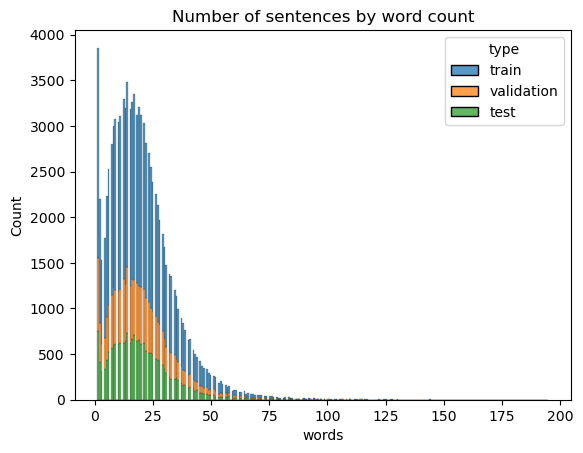

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


train_length = np.array([len(x) for x in train_corpus])
val_length = np.array([len(x) for x in valid_corpus])
test_length = np.array([len(x) for x in test_corpus])

stats_df = pd.DataFrame({"words": np.concatenate([train_length, val_length, test_length]),
                        "type": len(train_length)*["train"] +
                         len(val_length)*["validation"] + 
                         len(test_length)*["test"]})

sns.histplot(x="words", 
             hue="type", 
             data=stats_df, 
             multiple="stack")

plt.title("Number of sentences by word count")
tasks.util.save_plot("ex_6_dataset_stats.png", OUTPUT_DIR)
plt.show()